## First model - labeled CT data

In [1]:
!pip install opencv-python

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import tensorflow

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from tensorflow.keras import callbacks

from joblib import dump, load

You should consider upgrading via the '/home/adduser/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
def read_ct_img_bydir(target_dir):
    img=cv2.imdecode(np.fromfile(target_dir,dtype=np.uint8),cv2.IMREAD_GRAYSCALE)
    #img = corp_margin(img)
    img=cv2.resize(img,(200,200))
    
    return img

In [3]:
def get_data():
    '''Loads raw data from image names of each class folder and assigns a label to it.'''
    
    target_dir1='../raw_data/labeled_CT_data/NiCT/'
    target_dir2='../raw_data/labeled_CT_data/pCT/'
    target_dir3='../raw_data/labeled_CT_data/nCT_nd/'

    target_list1=[target_dir1+file for file in os.listdir(target_dir1)]
    target_list2=[target_dir2+file for file in os.listdir(target_dir2)]
    target_list3=[target_dir3+file for file in os.listdir(target_dir3)]

    target_list=target_list1+target_list2+target_list3

    # Assign labels: 0: 'non informative CT'
    #                1: 'positive Covid-19 CT'
    #                2: 'negative Covid-19 CT'
    y_list=to_categorical(np.concatenate(np.array([[0]*len(target_list1),
                                               [1]*len(target_list2),
                                               [2]*len(target_list3)])),3)

    X=np.array([read_ct_img_bydir(file) for file in target_list])[:,:,:,np.newaxis]

    return X, y_list

In [ ]:
# def corp_margin(img2):
#     img2=np.asarray(img2)
#     (row, col) = img2.shape
    
#     row_top = 0
#     raw_down = 0
#     col_top = 0
#     col_down = 0
    
#     axis1=img2.sum(axis=1)
#     axis0=img2.sum(axis=0)
    
#     for r in range(0, row):
#         if axis1[r] > 30:
#             row_top = r
#             break
            
#     for r in range(row - 1, 0, -1):
#         if axis1[r] > 30:
#             raw_down = r
#             break
            
#     for c in range(0, col):
#         if axis0[c] > 30:
#             col_top = c
#             break
            
#     for c in range(col - 1, 0, -1):
#         if axis0[c] > 30:
#             col_down = c
#             break
            
#     a=raw_down+ 1 - row_top-(col_down+ 1-col_top)
    
#     if a>0:
#             w=raw_down+ 1-row_top
#             col_down=int((col_top+col_down + 1)/2+w/2)
#             col_top = col_down-w
            
#             if col_top < 0:
#                 col_top = 0
#                 col_down = col_top + w
                
#             elif col_down >= col:
#                 col_down = col - 1
#                 col_top = col_down - w
#     else:
#             w=col_down + 1- col_top
#             raw_down = int((row_top + raw_down + 1) / 2 + w/2)
#             row_top =  raw_down-w
            
#             if row_top < 0:
#                 row_top = 0
#                 raw_down = row_top + w                
                
#             elif raw_down >= row:
#                 raw_down = row - 1
#                 row_top = raw_down - w
                
#     if row_top==raw_down:
#         row_top=0
#         raw_down=99
#         col_top = 0
#         col_down = 99
#     new_img = img2[row_top:raw_down + 1, col_top:col_down + 1]
#     return new_img


In [4]:
X,y = get_data()

In [5]:
X.shape

(16689, 200, 200, 1)

In [6]:
y.shape

(16689, 3)

In [7]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [8]:
X[0].shape

(200, 200, 1)

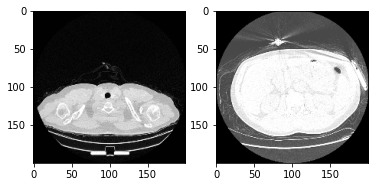

In [9]:
#plt.figure(figsize=(20,15))

plt.subplot(1,2,1)
plt.imshow(X[0], cmap="gray");
plt.subplot(1,2,2)
plt.imshow(X[9], cmap="gray");

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
y_test[1]

array([0., 1., 0.], dtype=float32)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential()
model.add(layers.Conv2D(64, (3,3), input_shape=(200, 200, 1), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Conv2D(32, (3,3), activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2))) 

model.add(layers.Dense(32, activation="relu"))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation="softmax"))

# The compilation
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics = ['accuracy'])  # Recommanded optimizer for RNN


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        1

In [14]:
# The fit

es = callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=15,
                    validation_split=0.3,
                    callbacks=[es],
                    verbose=1)

Epoch 1/15
256/256 [==============================] - 826s 3s/step - loss: 1.6309 - accuracy: 0.6845 - val_loss: 0.2335 - val_accuracy: 0.9170
Epoch 2/15
256/256 [==============================] - 776s 3s/step - loss: 0.1291 - accuracy: 0.9549 - val_loss: 0.0711 - val_accuracy: 0.9735
Epoch 3/15
256/256 [==============================] - 795s 3s/step - loss: 0.0534 - accuracy: 0.9818 - val_loss: 0.0324 - val_accuracy: 0.9883
Epoch 4/15
256/256 [==============================] - 793s 3s/step - loss: 0.0341 - accuracy: 0.9873 - val_loss: 0.0359 - val_accuracy: 0.9889
Epoch 5/15
256/256 [==============================] - 820s 3s/step - loss: 0.0305 - accuracy: 0.9913 - val_loss: 0.0582 - val_accuracy: 0.9817
Epoch 6/15
256/256 [==============================] - 840s 3s/step - loss: 0.0516 - accuracy: 0.9839 - val_loss: 0.0240 - val_accuracy: 0.9923
Epoch 7/15
256/256 [==============================] - 827s 3s/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.0154 - val_accuracy: 0.9943

In [15]:
## The prediction
y_pred = model.predict(X_test)

In [16]:
y_pred.shape

(5007, 3)

In [17]:
y_pred[0]

array([1.5104996e-24, 4.0811027e-17, 1.0000000e+00], dtype=float32)

In [18]:
y_pred_class = np.rint(y_pred)

In [19]:
y_pred_class

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [20]:
pred = model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 80s 507ms/step - loss: 0.0169 - accuracy: 0.9952


In [21]:
pred

[0.0168897844851017, 0.9952067136764526]

In [22]:
# save model
model.save('model_labeled_ct_15epochs')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: model_labeled_ct_15epochs/assets


In [23]:
# Load
from tensorflow.keras.models import load_model
model_loaded = load_model('model_labeled_ct_15epochs')

In [24]:
# # save model
# model.save('my_model')  # creates a HDF5 file 'my_model.h5'

In [25]:
pred_error = y_pred_class - y_test

In [26]:
x_plot = np.arange(len(y_test))
x_plot

array([   0,    1,    2, ..., 5004, 5005, 5006])

In [27]:
y_pred_class

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [28]:
y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [29]:
np.unique(pred_error)

array([-1.,  0.,  1.], dtype=float32)

In [30]:
predict_errors = list()

for i in range(len(pred_error)):
    predict_errors.append(pred_error[i,0] + pred_error[i,1]+ pred_error[i,2])
predict_errors[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

In [31]:
y_pred

array([[1.5104996e-24, 4.0811027e-17, 1.0000000e+00],
       [4.0297432e-09, 9.9999619e-01, 3.7584400e-06],
       [5.8603109e-15, 1.0811038e-06, 9.9999893e-01],
       ...,
       [9.9999988e-01, 1.4099761e-07, 5.5630156e-08],
       [9.7563982e-23, 4.7901141e-09, 1.0000000e+00],
       [1.0000000e+00, 4.4810439e-13, 3.8393524e-09]], dtype=float32)

In [32]:
test_pred = model_loaded.predict(X_test)

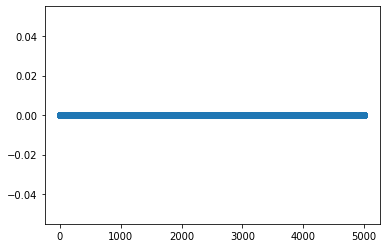

In [33]:
plt.scatter(x_plot, predict_errors);

In [34]:
np.unique(predict_errors)

array([0.], dtype=float32)

In [35]:
int_errors = [int(a) for a in predict_errors]

In [37]:
int_errors;

In [38]:
y_df = pd.DataFrame(y)

In [39]:
col1 = y_df[0].sum()
col2 = y_df[1].sum()
col3 = y_df[2].sum()

In [40]:
print('# non-informative labeled CTs: ',col1)
print('# positive labeled CTs: ',col2)
print('# negative labeled CTs: ',col3)

# non-informative labeled CTs:  3113.0
# positive labeled CTs:  4001.0
# negative labeled CTs:  9575.0


In [41]:
cols = [col1, col2,col3]

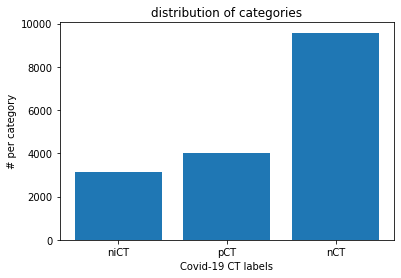

In [49]:
plt.bar(['niCT','pCT','nCT'], cols)
plt.title('distribution of categories');
plt.ylabel('# per category');
plt.xlabel('Covid-19 CT labels');

In [43]:
model_loaded.predict(X_test)

array([[1.5104996e-24, 4.0811027e-17, 1.0000000e+00],
       [4.0297432e-09, 9.9999619e-01, 3.7584400e-06],
       [5.8603109e-15, 1.0811038e-06, 9.9999893e-01],
       ...,
       [9.9999988e-01, 1.4099761e-07, 5.5630156e-08],
       [9.7563982e-23, 4.7901141e-09, 1.0000000e+00],
       [1.0000000e+00, 4.4810439e-13, 3.8393524e-09]], dtype=float32)